In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
SPY = pd.read_csv('SPY.csv', index_col = 0)
AAPL = pd.read_csv('AAPL.O.csv', index_col = 0)
AMZN = pd.read_csv('AMZN.O.csv', index_col = 0)
GOOG = pd.read_csv('GOOG.O.csv', index_col = 0)
META = pd.read_csv('META.O.csv', index_col = 0)
MSFT = pd.read_csv('MSFT.O.csv', index_col = 0)
NVDA = pd.read_csv('NVDA.O.csv', index_col = 0)
TSLA = pd.read_csv('TSLA.O.csv', index_col = 0)

In [3]:
Mag_7 = ['AAPL', 
         'MSFT', 
         'GOOG', 
         'AMZN', 
         'META', 
         'NVDA', 
         'TSLA']

In [4]:
data = pd.DataFrame(index = SPY.index)
data['SPY'] = SPY['Adj Close']
data['AAPL'] = AAPL['CLOSE']
data['MSFT'] = MSFT['CLOSE']
data['GOOG'] = GOOG['CLOSE']
data['AMZN'] = AMZN['CLOSE']
data['META'] = META['CLOSE']
data['NVDA'] = NVDA['CLOSE']
data['TSLA'] = TSLA['CLOSE']
data.dropna(inplace = True)

In [24]:
returns = data.pct_change()

In [6]:
mkt_cap = pd.DataFrame(index = AAPL.index)
mkt_cap['AAPL'] = AAPL['MKT_CAP_ARD']
mkt_cap['MSFT'] = MSFT['MKT_CAP_ARD']
mkt_cap['GOOG'] = GOOG['MKT_CAP_ARD']
mkt_cap['AMZN'] = AMZN['MKT_CAP_ARD']
mkt_cap['META'] = META['MKT_CAP_ARD']
mkt_cap['NVDA'] = NVDA['MKT_CAP_ARD']
mkt_cap['TSLA'] = TSLA['MKT_CAP_ARD']
mkt_cap.dropna(inplace = True)

In [8]:
interest_rate = pd.DataFrame(0, index = data.index, columns=["Rate"])

In [ ]:
data.index[0], data.index[-1]

In [13]:
# Backtest Params
lookback = 200
observe = 100
weigh_flag = "Market Cap"

for i in range(lookback + 1, len(data.index) - observe):
    date = data.index[i]
    
    # Portfolio weights for this day
    if weigh_flag == "Market Cap":
        daily_mkt_cap = {ticker : mkt_cap.loc[date, ticker] for ticker in Mag_7}
        denominator = sum(daily_mkt_cap.values())
        portfolio = {ticker : daily_mkt_cap[ticker] / denominator for ticker in Mag_7}
    
    elif weigh_flag == "Equal":
        portfolio = {ticker : 1.0/7 for ticker in Mag_7}
    
    # Portfolio beta during lookback
    beta = {ticker : 0} 
    SPY_returns = returns.iloc[i - 200 : i, "SPY"]
    for ticker in Mag_7:
        asset_returns = returns.loc

In [9]:
returns.head()

,SPY,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA
Date,,,,,,,,
2014-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-28,0.004930,-0.001116,0.023882,0.002740,-0.000532,-0.015745,0.006183,0.024358
2014-03-31,0.008194,-0.000224,0.017122,-0.005393,-0.005690,0.003833,0.000559,-0.018458
2014-04-01,0.006631,0.009148,0.010490,0.018295,0.019696,0.039509,0.041318,0.040873
2014-04-02,0.003346,0.001662,-0.001690,-0.000282,-0.003003,0.001597,-0.006434,0.061391


In [25]:
lookback = 200
observe = 100
weigh_flag = "Market Cap"
beta_STD = 0.2

i = lookback + 1
date = data.index[i]

daily_mkt_cap = {ticker : mkt_cap.loc[date, ticker] for ticker in Mag_7}
denominator = sum(daily_mkt_cap.values())
portfolio = {ticker : daily_mkt_cap[ticker] / denominator for ticker in Mag_7}

beta = {}
return_samples = returns.iloc[i - lookback : i, :]
rate_samples = interest_rate.iloc[i - lookback : i, :]

for ticker in Mag_7:
    X = return_samples["SPY"] - rate_samples["Rate"]  # Currently Assumed 0
    y = return_samples[ticker] - rate_samples["Rate"]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    beta[ticker] = model.params.iloc[1]
    
portfolio_beta = sum([beta[ticker] * portfolio[ticker] for ticker in Mag_7])

# Sample with Gaussian Distribution N(portfolio_beta, beta_STD)
normal_betas = np.random.normal(loc = portfolio_beta, scale = beta_STD, size = 10000)
return_results = []

return_samples = returns.iloc[i : i + observe, :]
beta_return_sets = []

for sample_beta in normal_betas:
    portfolio["SPY"] = -sample_beta
    portfolio_returns = []
    
    for future_date in return_samples.index:
        daily_return = sum([return_samples.loc[future_date, ticker] * portfolio[ticker] for ticker in portfolio])
        portfolio_returns.append(daily_return)
        
    return_results.append(np.mean(portfolio_returns) * 250)
    beta_return_sets.append((sample_beta, np.mean(portfolio_returns) * 250))

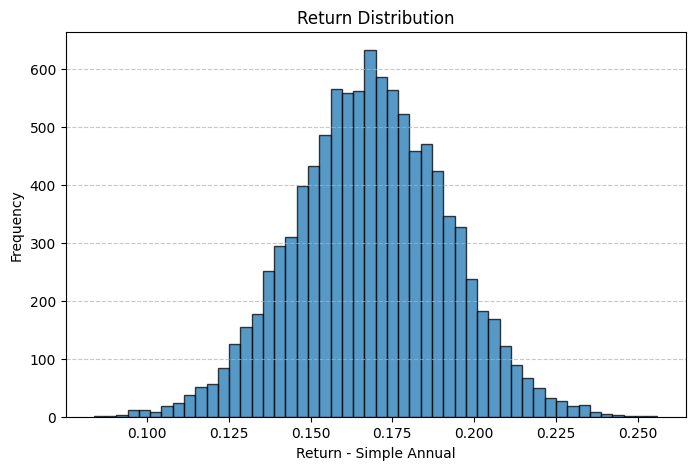

In [26]:
plt.figure(figsize=(8, 5))
plt.hist(return_results, bins=50, edgecolor="black", alpha=0.75)

plt.xlabel("Return - Simple Annual")
plt.ylabel("Frequency")
plt.title("Return Distribution")

# Show grid and plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()